# Strategies for allocating absentee votes

- Areal allocation
- Total population
- Voting age population
- Registered voters
- Election day votes, by party

In [130]:
import pandas
import geopandas
import maup
from shapely.ops import unary_union
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = geopandas.read_file("./shapefiles/GA_precincts16_absentee_initial.shp")

In [3]:
data = pandas.DataFrame({
    "D_INPERSON": df[["PRES16D_ED", "PRES16D_AD"]].sum(axis=1),
    "R_INPERSON": df[["PRES16R_ED", "PRES16R_AD"]].sum(axis=1),
    "D_ABSENTEE": df["PRES16D_AB"],
    "R_ABSENTEE": df["PRES16R_AB"],
})

In [10]:
to_allocate = ["D_ABSENTEE", "R_ABSENTEE"]

In [7]:
df = df.join(data)

In [15]:
df.crs

{'init': 'epsg:26966'}

In [9]:
assignment = df["CTYNAME"]

In [27]:
county_area = geopandas.GeoSeries(df.geometry.groupby(assignment).apply(unary_union), crs=df.crs).area

In [33]:
county_data_to_prorate = df[to_allocate].groupby(assignment).sum()

In [34]:
weights = df.area / assignment.map(county_area)
prorated = maup.prorate(assignment, county_data_to_prorate, weights)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E20B19D9E8>,
      dtype=object)

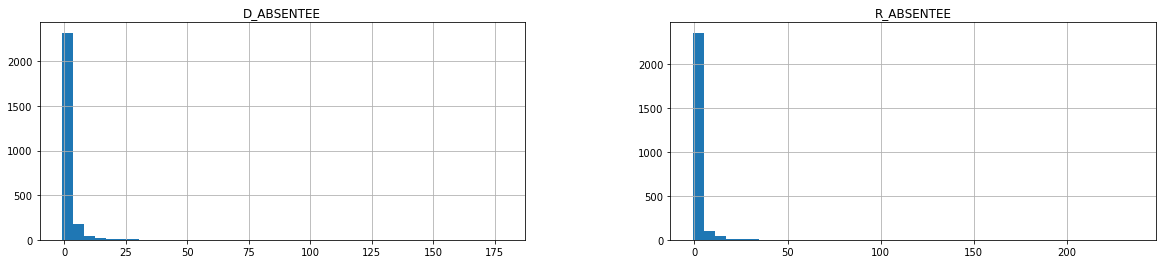

In [60]:
errors_by_area = (prorated - df[to_allocate])/df[to_allocate]
errors_by_area = errors_by_area[errors_by_area < np.inf]
errors_by_area.hist(figsize=(20, 4), bins=40)

In [99]:
(prorated - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    76742.517204
R_ABSENTEE    74196.378548
dtype: float64

In [98]:
(prorated_by_pop - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    38733.722836
R_ABSENTEE    45388.854122
dtype: float64

In [61]:
county_pops = df.TOTPOP.groupby(assignment).sum()
pop_weights = df.TOTPOP / assignment.map(county_pops)
prorated_by_pop = maup.prorate(assignment, county_data_to_prorate, pop_weights)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E20B323978>,
      dtype=object)

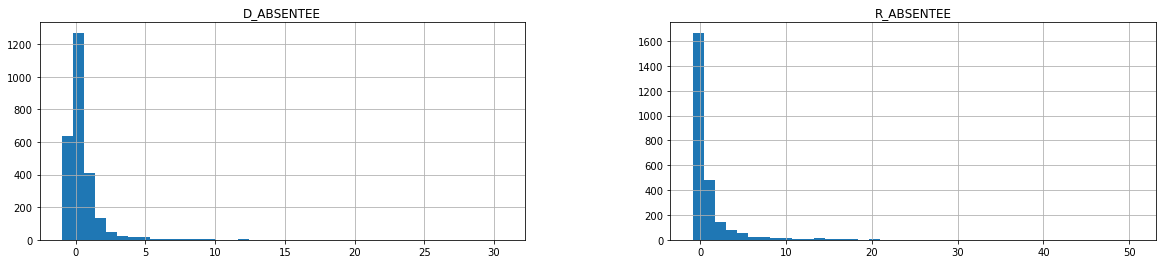

In [65]:
errors_by_pop = (prorated_by_pop - df[to_allocate])/df[to_allocate]
errors_by_pop = errors_by_pop[errors_by_pop < np.inf]
errors_by_pop.hist(figsize=(20, 4), bins=40)

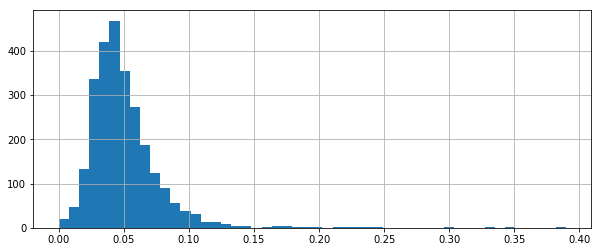

In [68]:
(df[to_allocate].sum(axis=1) / df[["PRES16R", "PRES16D"]].sum(axis=1)).hist(figsize=(10, 4), bins=50)

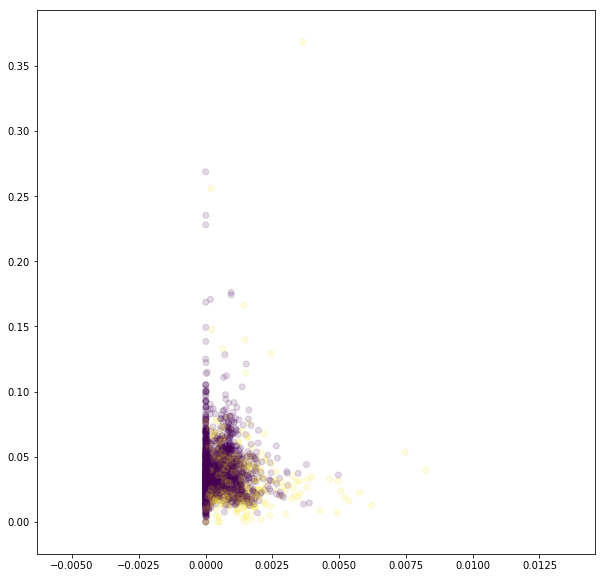

In [89]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(
    y=(df[["PRES16D_AB", "PRES16R_AB"]].sum(axis=1) / df.REG_VOTE), 
    x=df.TOTPOP/df.area,
    c=(df["CTYNAME"] == "Fulton"),
    alpha=0.15
)


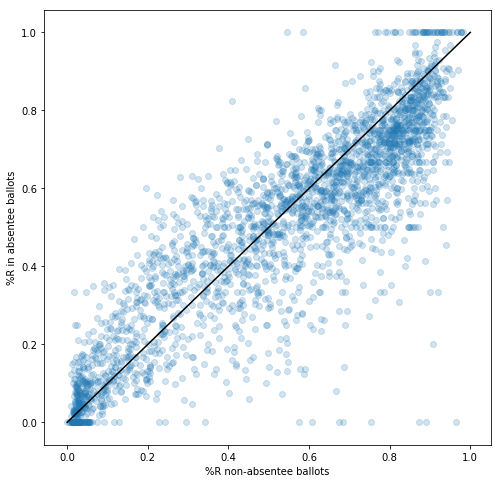

In [196]:
tot_non_abs_votes = df[["PRES16R_ED", "PRES16D_ED", "PRES16R_AD", "PRES16D_AD"]].sum(axis=1)
tot_abs_votes = df[["PRES16R_AB", "PRES16D_AB"]].sum(axis=1)
pct_r_non_abs = df[["PRES16R_ED", "PRES16R_AD"]].sum(axis=1) / tot_ed_votes
pct_r_abs = df["PRES16R_AB"] / tot_abs_votes

plt.figure(figsize=(8, 8))
plt.scatter(
    x=pct_r_non_abs,
    y=pct_r_abs,
    alpha=0.2,
)

xy_line = np.arange(0, 11) / 10
plt.plot(xy_line, xy_line, c="black")
plt.xlabel("%R non-absentee ballots")
plt.ylabel("%R in absentee ballots")
plt.show()

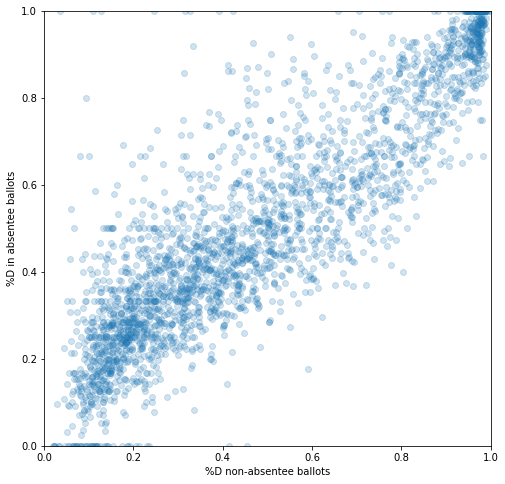

In [265]:
pct_d_non_abs = df[["PRES16D_ED", "PRES16D_AD"]].sum(axis=1) / tot_ed_votes
pct_d_abs = df["PRES16D_AB"] / tot_abs_votes

# fit = np.polyfit(pct_d_non_abs, pct_d_abs, 1)
# fit_fn = np.poly1d(fit)

plt.figure(figsize=(8, 8))

plt.scatter(
    x=pct_d_non_abs,
    y=pct_d_abs,
    alpha=0.2
)
x = pct_d_non_abs
xy_line = np.arange(0, 11) / 10
# plt.plot(xy_line, xy_line, c="black")
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.plot(pct_d_non_abs, pct_abs, 'yo', x, fit_fn(x), '--k')
plt.xlabel("%D non-absentee ballots")
plt.ylabel("%D in absentee ballots")
plt.show()

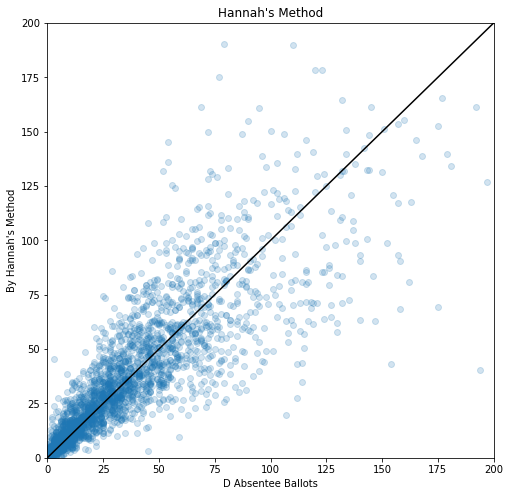

In [389]:
# fit = np.polyfit(pct_d_non_abs, pct_d_abs, 1)
# fit_fn = np.poly1d(fit)

plt.figure(figsize=(8, 8))

plt.scatter(
    x=df["D_ABSENTEE"],
    y=d_prorated,
    alpha=0.2,
)
xy_line = np.arange(0, 1000, 100)
plt.plot(xy_line, xy_line, c="black")
plt.xlim(0, 200)
plt.ylim(0, 200)
# plt.plot(pct_d_non_abs, pct_abs, 'yo', x, fit_fn(x), '--k')
plt.xlabel("D Absentee Ballots")
plt.ylabel("By Hannah's Method")
plt.title("Hannah's Method")
plt.show()

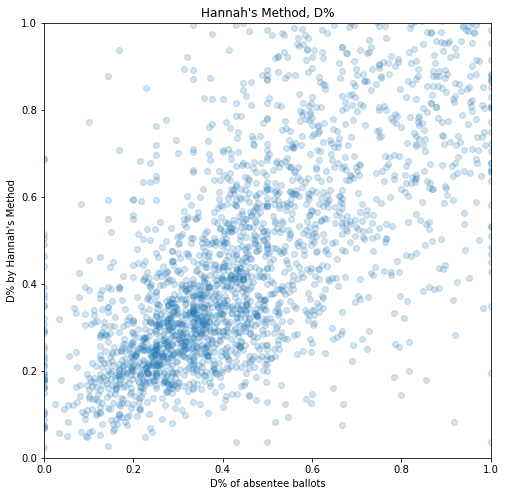

In [390]:
# fit = np.polyfit(pct_d_non_abs, pct_d_abs, 1)
# fit_fn = np.poly1d(fit)

plt.figure(figsize=(8, 8))

plt.scatter(
    x=df["D_ABSENTEE"] / df[["D_ABSENTEE", "R_ABSENTEE"]].sum(axis=1),
    y=d_prorated / df[["D_ABSENTEE", "R_ABSENTEE"]].sum(axis=1),
    alpha=0.2,
)
# xy_line = np.arange(0, 1000, 100)
# plt.plot(xy_line, xy_line, c="black")
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.plot(pct_d_non_abs, pct_abs, 'yo', x, fit_fn(x), '--k')
plt.xlabel("D% of absentee ballots")
plt.ylabel("D% by Hannah's Method")
plt.title("Hannah's Method, D%")
plt.show()

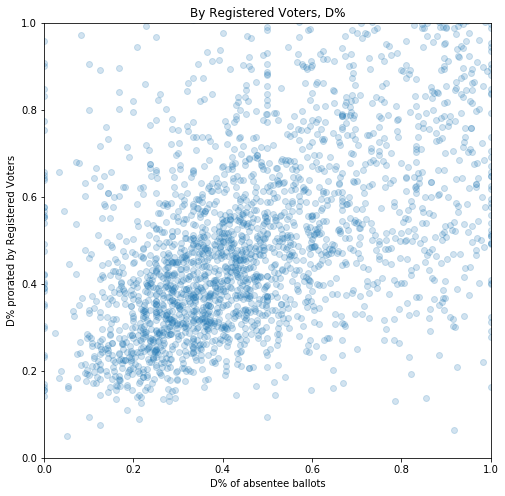

In [391]:
# fit = np.polyfit(pct_d_non_abs, pct_d_abs, 1)
# fit_fn = np.poly1d(fit)

plt.figure(figsize=(8, 8))

plt.scatter(
    x=df["D_ABSENTEE"] / df[["D_ABSENTEE", "R_ABSENTEE"]].sum(axis=1),
    y=prorated_by_reg["D_ABSENTEE"] / df[["D_ABSENTEE", "R_ABSENTEE"]].sum(axis=1),
    alpha=0.2,
)
# xy_line = np.arange(0, 1000, 100)
# plt.plot(xy_line, xy_line, c="black")
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.plot(pct_d_non_abs, pct_abs, 'yo', x, fit_fn(x), '--k')
plt.xlabel("D% of absentee ballots")
plt.ylabel("D% prorated by Registered Voters")
plt.title("By Registered Voters, D%")
plt.show()

In [405]:
real_absentee_d_pct = df["D_ABSENTEE"] / df[["D_ABSENTEE", "R_ABSENTEE"]].sum(axis=1),

for d, name in zip([prorated_by_reg, prorated_by_vap, hannahs_way, prorated], ["reg", "vap", "hannah", "area"]):
    print(name)
    print(np.sqrt((d[to_allocate] - df[to_allocate]).apply(lambda x: x**2).mean()))
    print()

reg
D_ABSENTEE    23.246515
R_ABSENTEE    21.774055
dtype: float64

vap
D_ABSENTEE    26.014283
R_ABSENTEE    26.441935
dtype: float64

hannah
D_ABSENTEE    22.891603
R_ABSENTEE    15.584870
dtype: float64

area
D_ABSENTEE    55.944279
R_ABSENTEE    47.535223
dtype: float64



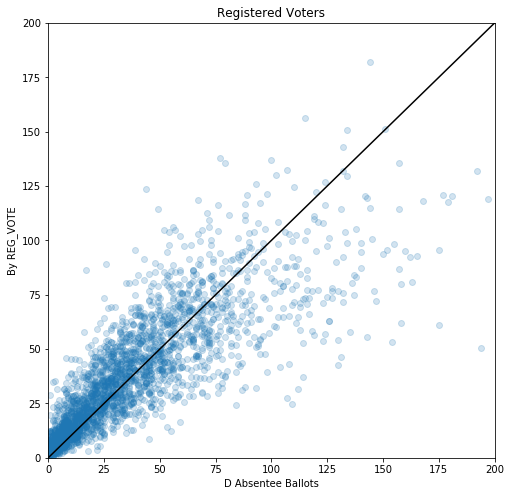

In [248]:
# fit = np.polyfit(pct_d_non_abs, pct_d_abs, 1)
# fit_fn = np.poly1d(fit)

plt.figure(figsize=(8, 8))

plt.scatter(
    x=df["D_ABSENTEE"],
    y=prorated_by_reg["D_ABSENTEE"],
    alpha=0.2
)
xy_line = np.arange(0, 1000, 100)
plt.plot(xy_line, xy_line, c="black")
plt.xlim(0, 200)
plt.ylim(0, 200)
# plt.plot(pct_d_non_abs, pct_abs, 'yo', x, fit_fn(x), '--k')
plt.xlabel("D Absentee Ballots")
plt.ylabel("By REG_VOTE")
plt.title("Registered Voters")
plt.show()

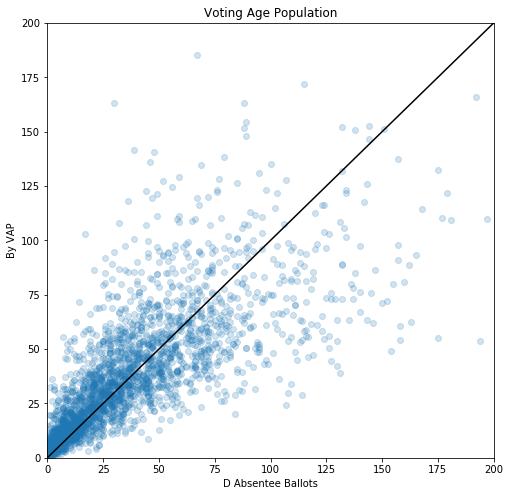

In [249]:
# fit = np.polyfit(pct_d_non_abs, pct_d_abs, 1)
# fit_fn = np.poly1d(fit)

plt.figure(figsize=(8, 8))

plt.scatter(
    x=df["D_ABSENTEE"],
    y=prorated_by_vap["D_ABSENTEE"],
    alpha=0.2
)
xy_line = np.arange(0, 1000, 100)
plt.plot(xy_line, xy_line, c="black")
plt.xlim(0, 200)
plt.ylim(0, 200)
# plt.plot(pct_d_non_abs, pct_abs, 'yo', x, fit_fn(x), '--k')
plt.xlabel("D Absentee Ballots")
plt.ylabel("By VAP")
plt.title("Voting Age Population")
plt.show()

In [259]:
np.sqrt((prorated_by_vap - df[to_allocate]).apply(lambda p: p**2).mean())

D_ABSENTEE    26.014283
R_ABSENTEE    26.441935
dtype: float64

In [258]:
np.sqrt((prorated_by_reg - df[to_allocate]).apply(lambda p: p**2).mean())

D_ABSENTEE    23.246515
R_ABSENTEE    21.774055
dtype: float64

In [257]:
np.sqrt((hannahs_way - df[to_allocate]).apply(lambda p: p**2).mean())

D_ABSENTEE    22.891603
R_ABSENTEE    15.584870
dtype: float64

In [264]:
df[["PRES16R", "PRES16D"]].sum() / df[["PRES16R", "PRES16D"]].sum().sum()

PRES16R    0.525652
PRES16D    0.474348
dtype: float64

In [261]:
np.sqrt((prorated - df[to_allocate]).apply(lambda p: p**2).mean())

D_ABSENTEE    55.944279
R_ABSENTEE    47.535223
dtype: float64

In [262]:
np.sqrt((prorated_by_pop - df[to_allocate]).apply(lambda p: p**2).mean())

D_ABSENTEE    26.301913
R_ABSENTEE    26.715708
dtype: float64

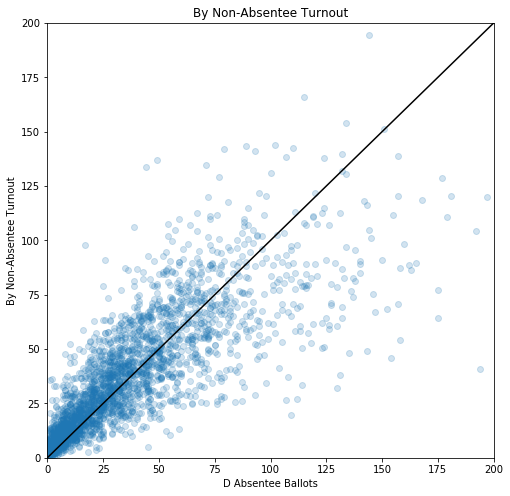

In [250]:
# fit = np.polyfit(pct_d_non_abs, pct_d_abs, 1)
# fit_fn = np.poly1d(fit)

plt.figure(figsize=(8, 8))

plt.scatter(
    x=df["D_ABSENTEE"],
    y=prorated_by_turnout["D_ABSENTEE"],
    alpha=0.2
)
xy_line = np.arange(0, 1000, 100)
plt.plot(xy_line, xy_line, c="black")
plt.xlim(0, 200)
plt.ylim(0, 200)
# plt.plot(pct_d_non_abs, pct_abs, 'yo', x, fit_fn(x), '--k')
plt.xlabel("D Absentee Ballots")
plt.ylabel("By Non-Absentee Turnout")
plt.title("By Non-Absentee Turnout")
plt.show()

In [243]:
(prorated_by_turnout - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    35058.731983
R_ABSENTEE    36178.180378
dtype: float64

In [245]:
(prorated_by_reg - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    33207.859833
R_ABSENTEE    38048.966915
dtype: float64

In [137]:
r_weights = (
    df["R_INPERSON"] /
    assignment.map(df["R_INPERSON"].groupby(assignment).sum())
)

In [138]:
r_prorated = maup.prorate(assignment, county_data_to_prorate["R_ABSENTEE"], r_weights)

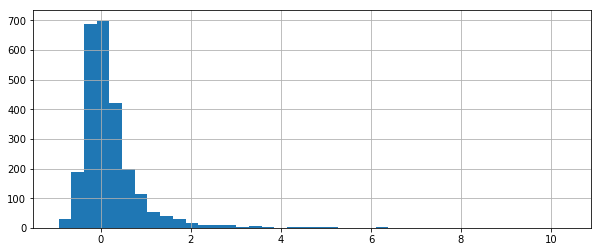

In [143]:
e = ((r_prorated - df["R_ABSENTEE"]) / df["R_ABSENTEE"])
e = e[df["R_ABSENTEE"] > 0]
e.hist(bins=40, figsize=(10, 4))

In [244]:
(hannahs_way - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    31311.979846
R_ABSENTEE    25040.921324
dtype: float64

In [145]:
d_weights = (
    df["D_INPERSON"] /
    assignment.map(df["D_INPERSON"].groupby(assignment).sum())
)
d_prorated = maup.prorate(assignment, county_data_to_prorate["D_ABSENTEE"], d_weights)

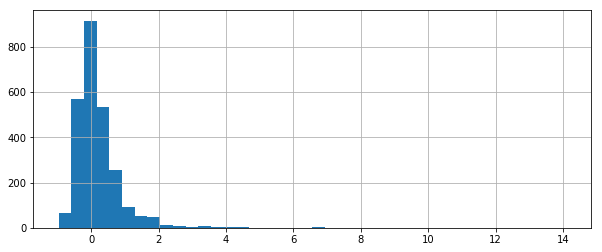

In [146]:
d_errors = ((d_prorated - df["D_ABSENTEE"]) / df["D_ABSENTEE"])
d_errors = d_errors[df["D_ABSENTEE"] > 0]
d_errors.hist(bins=40, figsize=(10, 4))

In [148]:
(d_prorated - df["D_ABSENTEE"]).apply(abs).sum()

31311.97984619414

In [194]:
(prorated_by_pop - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    38733.722836
R_ABSENTEE    45388.854122
dtype: float64

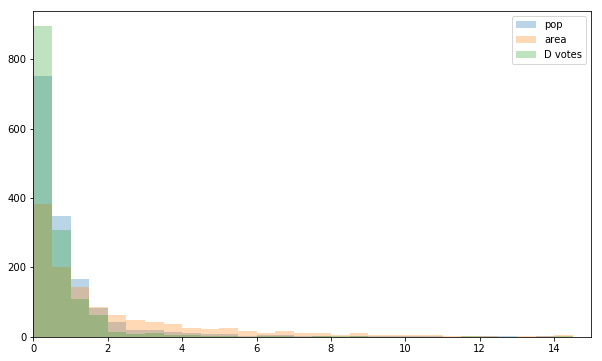

In [297]:
by_pop_d_error = (prorated_by_pop["D_ABSENTEE"] - df["D_ABSENTEE"]) / df["D_ABSENTEE"]
by_area_d_error = (prorated["D_ABSENTEE"] - df["D_ABSENTEE"]) / df["D_ABSENTEE"]
by_d_votes_d_error = (d_prorated - df["D_ABSENTEE"]) / df["D_ABSENTEE"]
by_reg_d_error = (prorated_by_reg["D_ABSENTEE"] - df["D_ABSENTEE"]) / df["D_ABSENTEE"]
nonzero = df["D_ABSENTEE"] > 0
bins = np.arange(0, 30) / 2

plt.figure(figsize=(10, 6))
plt.hist(by_pop_d_error[nonzero], bins=bins, alpha=0.3, label="pop")
plt.hist(by_area_d_error[nonzero], bins=bins, alpha=0.3, label="area")
plt.hist(by_d_votes_d_error[nonzero], bins=bins, alpha=0.3, label="D votes")
# plt.hist(by_reg_d_error[nonzero], bins=bins, alpha=0.2, label="REG_VOTE")
plt.legend()
plt.xlim(0, 15)
plt.show()

In [160]:
fulton = df[df["COUNTY"] == "Fulton"]

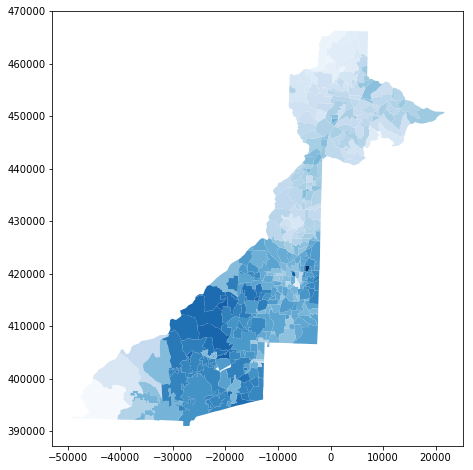

In [161]:
fulton.plot(column=fulton["PRES16D"] / fulton["REG_VOTE"], cmap="Blues", figsize=(10, 8))

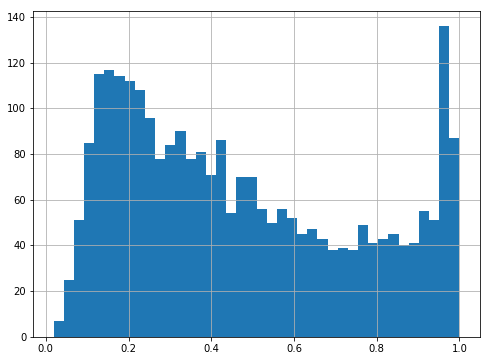

In [166]:
(df["PRES16D"] / df[["PRES16D", "PRES16R"]].sum(axis=1)).hist(bins=40, figsize=(8, 6))

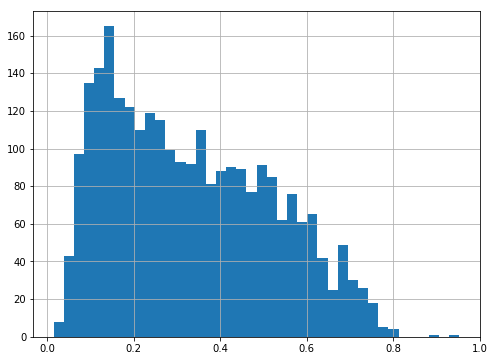

In [167]:
(df["PRES16D"] / df["REG_VOTE"]).hist(bins=40, figsize=(8, 6))

Text(0, 0.5, 'D%')

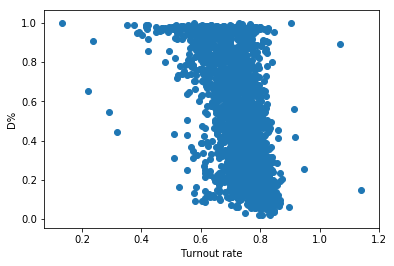

In [169]:
plt.scatter(x = (df[["PRES16D", "PRES16R"]].sum(axis=1) / df["REG_VOTE"]), y=(df["PRES16D"] / df[["PRES16D", "PRES16R"]].sum(axis=1)))
plt.xlabel("Turnout rate")
plt.ylabel("D%")

In [205]:
vap_weights = df.VAP / assignment.map(df.VAP.groupby(df.CTYNAME).sum())
prorated_by_vap = maup.prorate(assignment, county_data_to_prorate, vap_weights)

In [206]:
(prorated_by_vap - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    38246.668823
R_ABSENTEE    44807.875713
dtype: float64

In [174]:
reg_weights = df.REG_VOTE / assignment.map(df.REG_VOTE.groupby(df.CTYNAME).sum())
prorated_by_reg = maup.prorate(assignment, county_data_to_prorate, reg_weights)

In [241]:
inperson_votes = df[["D_INPERSON", "R_INPERSON"]].sum(axis=1)
turnout_weights = inperson_votes / assignment.map(inperson_votes.groupby(df.CTYNAME).sum())
prorated_by_turnout = maup.prorate(assignment, county_data_to_prorate, turnout_weights)

In [175]:
(prorated_by_reg - df[to_allocate]).apply(abs).sum()

D_ABSENTEE    33207.859833
R_ABSENTEE    38048.966915
dtype: float64

In [189]:
r_ed_weights = (
    df["PRES16R_ED"] /
    assignment.map(df["PRES16R_ED"].groupby(assignment).sum())
)
d_ed_weights = (
    df["PRES16D_ED"] /
    assignment.map(df["PRES16D_ED"].groupby(assignment).sum())
)

In [190]:
r_ed_prorated = maup.prorate(assignment, county_data_to_prorate["R_ABSENTEE"], r_ed_weights)
d_ed_prorated = maup.prorate(assignment, county_data_to_prorate["D_ABSENTEE"], d_ed_weights)

In [185]:
(r_ed_prorated - df["R_ABSENTEE"]).apply(abs).sum()

33333.58186625383

In [191]:
(d_ed_prorated - df["D_ABSENTEE"]).apply(abs).sum()

34513.45912330106

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E219C4F550>,
      dtype=object)

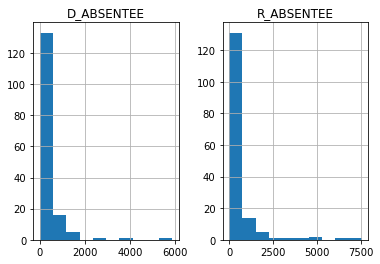

In [201]:
prorated_by_reg.groupby(df["CTYNAME"]).apply(np.var).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E21B247D68>,
      dtype=object)

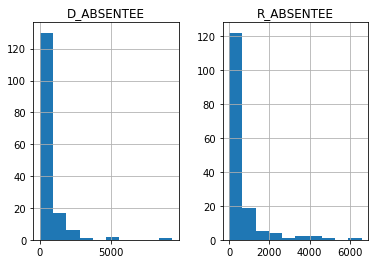

In [212]:
hannahs_way = pandas.DataFrame({"D_ABSENTEE": d_prorated, "R_ABSENTEE": r_prorated})

hannahs_way.groupby(df["CTYNAME"]).apply(np.var).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E219BE2FD0>,
      dtype=object)

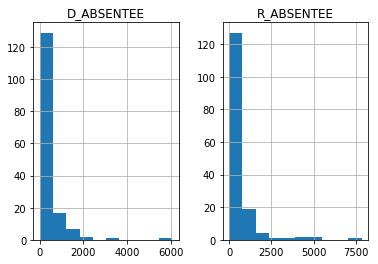

In [203]:
prorated_by_pop.groupby(df["CTYNAME"]).apply(np.var).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E219F68C88>,
      dtype=object)

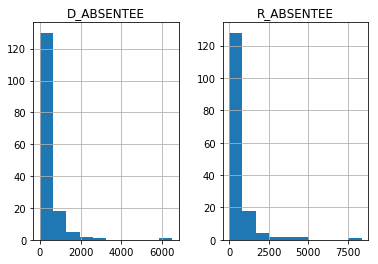

In [207]:
prorated_by_vap.groupby(df["CTYNAME"]).apply(np.var).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E219FFDDD8>,
      dtype=object)

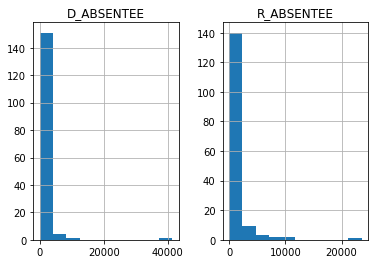

In [208]:
prorated.groupby(df["CTYNAME"]).apply(np.var).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E214F111D0>,
      dtype=object)

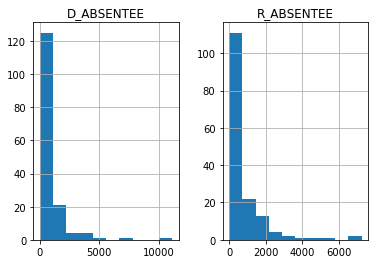

In [209]:
df[to_allocate].groupby(df["CTYNAME"]).apply(np.var).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E21CEB8978>,
      dtype=object)

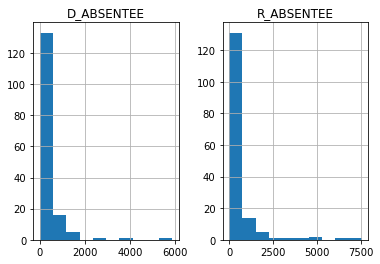

In [246]:
prorated_by_reg.groupby(df["CTYNAME"]).apply(np.var).hist()

In [211]:
df[to_allocate].apply(np.var)

D_ABSENTEE    1396.729749
R_ABSENTEE    1846.028574
dtype: float64

In [213]:
hannahs_way.apply(np.var)

D_ABSENTEE    1091.895163
R_ABSENTEE    1627.065526
dtype: float64

In [214]:
prorated.apply(np.var)

D_ABSENTEE    2626.814918
R_ABSENTEE    2510.954608
dtype: float64

In [215]:
prorated_by_pop.apply(np.var)

D_ABSENTEE     866.301472
R_ABSENTEE    1427.262932
dtype: float64

In [216]:
prorated_by_vap.apply(np.var)

D_ABSENTEE     858.563602
R_ABSENTEE    1416.495422
dtype: float64

In [217]:
prorated_by_reg.apply(np.var)

D_ABSENTEE     803.980602
R_ABSENTEE    1385.308821
dtype: float64

In [299]:
pct_votes_d = df["PRES16D"] / df[["PRES16D", "PRES16R"]].sum(axis=1)
pct_votes_absentee = df[["D_ABSENTEE", "R_ABSENTEE"]].sum(axis=1) / df[["PRES16D", "PRES16R"]].sum(axis=1)

Text(0.5, 0, 'D %')

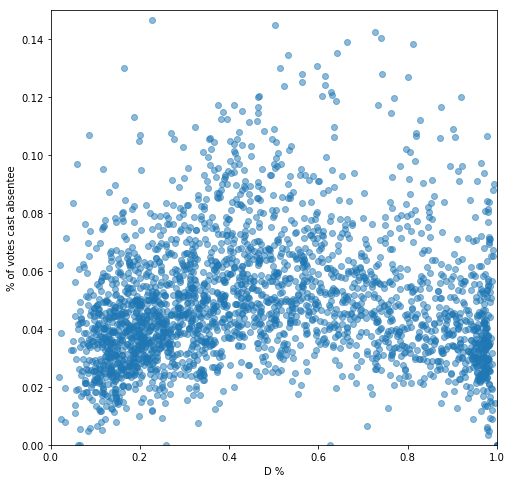

In [328]:
plt.figure(figsize=(8, 8))
# pandas.DataFrame({"absentee": pct_votes_absentee, "d_pct": pct_votes_d, "county": df["CTYNAME"]}).groupby("county").plot(kind="scatter", x="d_pct", y="absentee", subplots=True)
plt.scatter(y=pct_votes_absentee, x=pct_votes_d, alpha=0.5)
plt.ylim(0, 0.15)
plt.xlim(0, 1)
plt.ylabel("% of votes cast absentee")
plt.xlabel("D %")

Text(0.5, 0, 'D %')

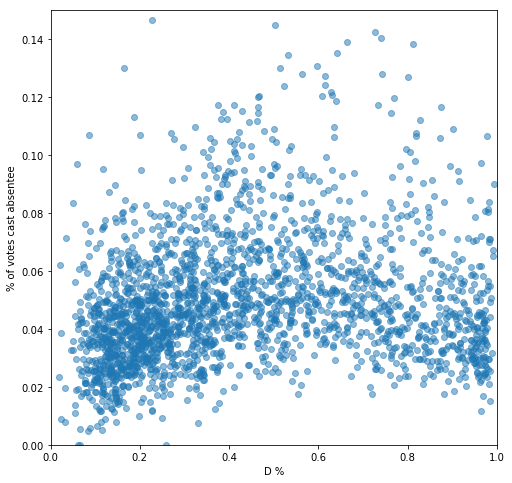

In [330]:
plt.figure(figsize=(8, 8))
# pandas.DataFrame({"absentee": pct_votes_absentee, "d_pct": pct_votes_d, "county": df["CTYNAME"]}).groupby("county").plot(kind="scatter", x="d_pct", y="absentee", subplots=True)
plt.scatter(y=pct_votes_absentee[df["CTYNAME"] != "Fulton"], x=pct_votes_d[df["CTYNAME"] != "Fulton"], alpha=0.5)
plt.ylim(0, 0.15)
plt.xlim(0, 1)
plt.ylabel("% of votes cast absentee")
plt.xlabel("D %")

In [345]:
county_sizes = df.groupby("CTYNAME").size()
big_counties = county_sizes[county_sizes >= 35]

In [346]:
len(big_counties)

11

In [351]:
data_to_scatter = pandas.DataFrame({
    "pop": df["TOTPOP"],
     "absentee": pct_votes_absentee,
     "d_pct": pct_votes_d,
     "county": df["CTYNAME"]
})

county
Chatham     [AxesSubplot(0.125,0.125;0.62x0.755)]
Cherokee    [AxesSubplot(0.125,0.125;0.62x0.755)]
Clayton     [AxesSubplot(0.125,0.125;0.62x0.755)]
Cobb        [AxesSubplot(0.125,0.125;0.62x0.755)]
Columbia    [AxesSubplot(0.125,0.125;0.62x0.755)]
DeKalb      [AxesSubplot(0.125,0.125;0.62x0.755)]
Fayette     [AxesSubplot(0.125,0.125;0.62x0.755)]
Fulton      [AxesSubplot(0.125,0.125;0.62x0.755)]
Gwinnett    [AxesSubplot(0.125,0.125;0.62x0.755)]
Henry       [AxesSubplot(0.125,0.125;0.62x0.755)]
Richmond    [AxesSubplot(0.125,0.125;0.62x0.755)]
dtype: object

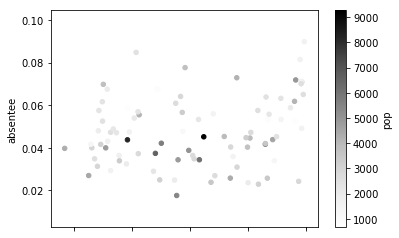

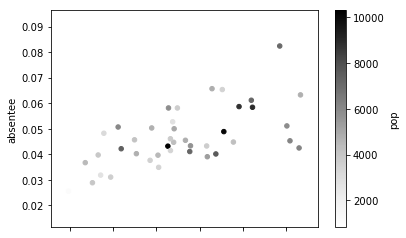

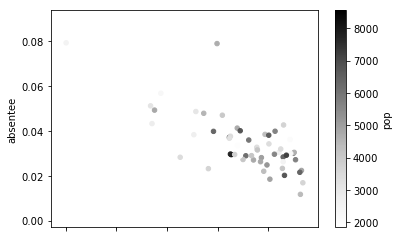

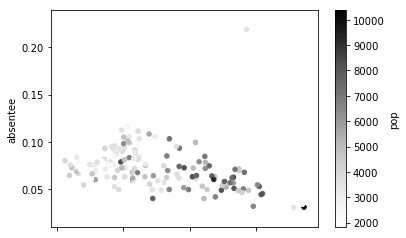

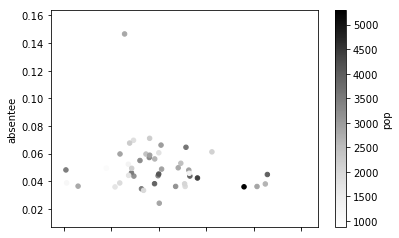

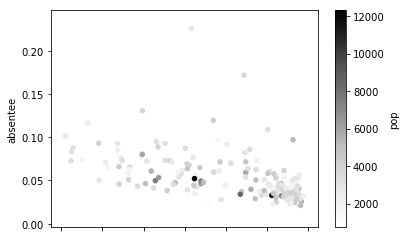

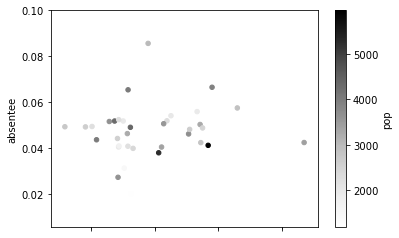

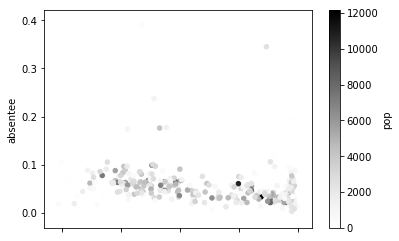

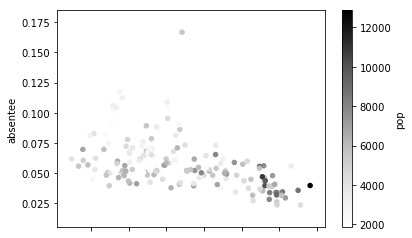

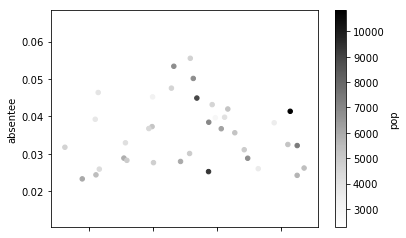

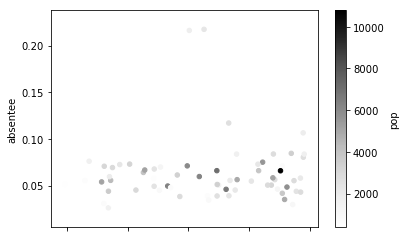

In [353]:
data_to_scatter[
    data_to_scatter["county"].isin(big_counties.index)
].groupby("county").plot(kind="scatter", x="d_pct", y="absentee", c="pop", subplots=True)

In [379]:
all_outputs = pandas.concat([
    d["D_ABSENTEE"] for d in
    [hannahs_way,
    prorated,
    prorated_by_pop,
    prorated_by_vap,
    prorated_by_reg]
], axis=1)

all_outputs_r = pandas.concat([
    d["R_ABSENTEE"] for d in
    [hannahs_way,
    prorated,
    prorated_by_pop,
    prorated_by_vap,
    prorated_by_reg]
], axis=1)

In [381]:
all_outputs.columns = ["hannah", "area", "pop", "vap", "reg"]
all_outputs_r.columns = ["hannah", "area", "pop", "vap", "reg"]

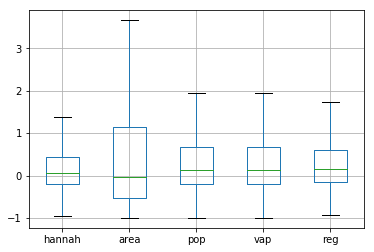

In [378]:
all_outputs.apply(lambda c: (c - df["D_ABSENTEE"])/df["D_ABSENTEE"], axis=0).boxplot(showfliers=False)

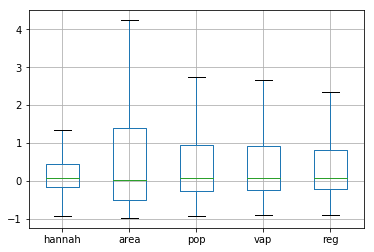

In [382]:
all_outputs_r.apply(lambda c: (c - df["R_ABSENTEE"])/df["R_ABSENTEE"], axis=0).boxplot(showfliers=False)